## Aim
#### Context
We plan to create a strkfarm managed wstETH/ETH strategy on Ekubo. We need data analysis of past data to suggest LP parameters to manage investment with max profit
End usage: We will be providing certain liquidity to this pool in the suggested range and we will also rebalance the position from time to time to maintain maximum fee output while keeping impermanent loss less
#### Methodology
Divide total available liquidity and swaps data into two parts: 70-30. 70% being used for training and optimisation, 30% used for testing the result
#### Expected output
Analyse the liquidity and swaps data of ETH/wstETH pool with best TVL
Suggest logic for configuring lower & upper ticks for adding liquidity along with conditions to trigger rebalance
Show strategy performance on the test data
_

⚠️ Note: Overfitting must be avoided. Do whatever optimisations u want on training data, once u run test on test data, share the result as it is. Do not optimise on test data.

## Detailed methodology
1. Install starknet.py to read events from ekubo using !pip install starknet.py (https://starknetpy.readthedocs.io/en/latest/account_creation.html)
2. Key concepts of ekubo: https://docs.ekubo.org/about-ekubo/key-concepts
3. Ekubo protocol, PositionUpdated and swap event's contract addresses are found through this. https://app.ekubo.org/charts/wstETH/ETH
4. Block number in which ekubo protocol has been created is found by looking at the "Ekubo positions NFT" the token address of this nft is obtained by looking at the transfer event preceding or succeeding the add liquidity event https://voyager.online/event/669266_158_2
https://voyager.online/tx/0x14cd53e2a6836e77da41706d4c6f0d07749c561acc3c52cd344fcc1ff920316
4. The value of pool fee and tick spacing is taken for the pool with highest TVL https://app.ekubo.org/charts/wstETH/ETH
5. To identify the notation in which pool fee and tick spacing are written refer to https://docs.ekubo.org/integration-guides/reference/reading-pool-price
6. Filtered events are then divided into 70% for training and 30% for testing. 
7. The training sample is used for simulating investment for different liquidity ranges and rebalance ranges. To identify the right range for liquidity and rebalancing. 
8. A fixed liquidity is taken for now and the fee is not computed as percentage. Once the initial testing is done and the formulae is verified, will make further changes. 


# Load required modules and classes

In [1]:
# Standard Library Imports
import math

# Third-Party Library Imports
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Local Imports
from src.data.ekubo_data import EkuboData  # Importing the EkuboData class
from src.strategies.ekubo_base import EkuboStrategyBase  # Importing the EkuboStrategyBase class
from src.utils.ekubo_math import get_token_order, get_pool_fee_touse, get_tick_spacing_touse

# Defining the constants to use

In [2]:
# Tokens in the LP
address1 = '0x42b8f0484674ca266ac5d08e4ac6a3fe65bd3129795def2dca5c34ecc5f96d2'  # wstETH
address2 = '0x49d36570d4e46f48e99674bd3fcc84644ddd6b96f7c741b1562b82f9e004dc7'  # ETH

token0_address, token1_address = get_token_order(address1, address2)
print(f"Token0 Address: {token0_address}, Token1 Address: {token1_address}")

# existing values from the website 
pool_fee = 0.001  # in %
tick_spacing = 0.002  # in %

# fee and tick spacing to use
pool_fee_touse = 3402823669209384797702963685910118
# pool_fee_touse = get_pool_fee_touse(pool_fee)
tick_spacing_touse = get_tick_spacing_touse(tick_spacing)
print(f"Pool Fee to use: {pool_fee_touse}")
print(f"Tick Spacing to use: {tick_spacing_touse}")

Token0 Address: 0x42b8f0484674ca266ac5d08e4ac6a3fe65bd3129795def2dca5c34ecc5f96d2, Token1 Address: 0x49d36570d4e46f48e99674bd3fcc84644ddd6b96f7c741b1562b82f9e004dc7
Pool Fee to use: 3402823669209384797702963685910118
Tick Spacing to use: 20


# Initializing EkuboData class for loading data

In [3]:
# Initialize the data loader with the required parameters
ekubo_data = EkuboData(
    client_url="https://starknet-mainnet.public.blastapi.io", 
    contract_address="0x00000005dd3d2f4429af886cd1a3b08289dbcea99a294197e9eb43b0e0325b4b", # Ekubo
    token0_address=token0_address,  # wstETH Address
    token1_address=token1_address,  # ETH Address
    pool_fee=pool_fee_touse,
    tick_spacing=tick_spacing_touse
)

# Load data from src/data

In [4]:
# Load events from files
events_response_positions_updated = ekubo_data.load_events_from_file('data_downloaded/events_response_positions_updated.pkl')
combined_events_response_swap = ekubo_data.load_events_from_file('data_downloaded/combined_events_response_swap.pkl')
# events_response_positions_updated = events_response_positions_updated.events
# print(events_response_positions_updated.events[0])
# print(combined_events_response_swap[0])

# Filter the data based on the liquidity pool, tick spacing and pool fee provided earlier

In [5]:
# Process the events to filter relevant data and create DataFrames
df_liquidity, df_swap = ekubo_data.process_events(events_response_positions_updated.events, combined_events_response_swap)

# Display the first few rows of the liquidity and swap DataFrames
print("Liquidity DataFrame:")
display(df_liquidity.head())
print(len(df_liquidity))
print("Swap DataFrame:")
display(df_swap.head())
print(len(df_swap))


Liquidity DataFrame:


,block_number,transaction_hash,delta_liquidity,tick_lower,tick_upper
0,655177,2879145539418839403171763982604352401380370371...,27408128235124552785321,158280,158460
1,655424,1279209847316592012798496238689033441847594858...,-99209107691145427163307,158400,158440
2,655424,2236106133222411803388378305320859355758706418...,262573697381870119149,158000,158800
3,655424,3387282097104070895993181893437770629177012930...,10990777850625690682059,158220,158860
4,655424,3779414541303248423459591667090630130681763650...,99205850788549541510734,158540,158580


576
Swap DataFrame:


,block_number,transaction_hash,price,tick_id,liquidity_after,amount0,amount1
0,655177,2416157948790894051047941157778594406573451511...,1.171710,158464,137703958037274544831372,-2256616757779677,2644126307134438
1,655177,2416157948790894051047941157778594406573451511...,1.171710,158464,137703958037274544831372,0,0
2,655179,1241404949126819184019688044659591190675013926...,1.171708,158463,137703958037274544831372,42668433630093793,-49994504035756152
3,655179,1241404949126819184019688044659591190675013926...,1.171708,158463,137703958037274544831372,-21336138963323289,25000000000000000
4,655179,1241404949126819184019688044659591190675013926...,1.171708,158463,137703958037274544831372,21334216438183549,-24997247385081083


20248


# Computing cummulative liquidity based on the liquidity and swap dataframes

In [6]:
# Compute the cumulative liquidity distribution for the training data
cumulative_liquidity_df = ekubo_data.compute_cumulative_liquidity(
    data_swap=df_swap.to_dict('records'), 
    data_liquidity=df_liquidity.to_dict('records'), 
    price_range_liquidity = 20 # in percentage +-from current price
)

# Display the cumulative liquidity DataFrame
print("Cumulative Liquidity DataFrame for Training Data:")
display(cumulative_liquidity_df.head())

# Analyze and visualize the cumulative liquidity for the last block in training data
last_block_data = cumulative_liquidity_df.iloc[-1]
last_block_number = last_block_data['block_number']
last_block_tick_liquidity = last_block_data['tick_liquidity_distribution']

# Note: The cummulative liquidity is currently not being used in this code. 

Cumulative Liquidity DataFrame for Training Data:


,block_number,tick_liquidity_distribution
0,655177,"{-64680: 0, -64660: 0, -64640: 0, -64620: 0, -..."
1,655179,"{-64680: 0, -64660: 0, -64640: 0, -64620: 0, -..."
2,655180,"{-64680: 0, -64660: 0, -64640: 0, -64620: 0, -..."
3,655183,"{-64680: 0, -64660: 0, -64640: 0, -64620: 0, -..."
4,655186,"{-64680: 0, -64660: 0, -64640: 0, -64620: 0, -..."


# Divide the swap data into 70-30% for training and testing respectively 

In [6]:
result = EkuboData.split_dataframes(df_swap, df_liquidity, split_ratio=0.7)
print("Split Block:", result['split_block'])
print("Max Block:", result['max_block'])
print("Min Block:", result['min_block'])

print("Training Swap DataFrame:")
display(result['train_swap_df'].head())
print("\nTesting Swap DataFrame:")
display(result['test_swap_df'].head())

print("\nTraining Liquidity DataFrame:")
display(result['train_liquidity_df'].head())
print("\nTesting Liquidity DataFrame:")
display(result['test_liquidity_df'].head())


Split Block: 666447
Max Block: 671277
Min Block: 655177
Training Swap DataFrame:


,block_number,transaction_hash,price,tick_id,liquidity_after,amount0,amount1
0,655177,2416157948790894051047941157778594406573451511...,1.171710,158464,137703958037274544831372,-2256616757779677,2644126307134438
1,655177,2416157948790894051047941157778594406573451511...,1.171710,158464,137703958037274544831372,0,0
2,655179,1241404949126819184019688044659591190675013926...,1.171708,158463,137703958037274544831372,42668433630093793,-49994504035756152
3,655179,1241404949126819184019688044659591190675013926...,1.171708,158463,137703958037274544831372,-21336138963323289,25000000000000000
4,655179,1241404949126819184019688044659591190675013926...,1.171708,158463,137703958037274544831372,21334216438183549,-24997247385081083



Testing Swap DataFrame:


,block_number,transaction_hash,price,tick_id,liquidity_after,amount0,amount1
13683,666448,1903276054207653061200648579526616639866312958...,1.17387,160306,11346195275753762193653033,-10042534198831409,11788755094454503
13684,666449,1608441755630721589754255098830551190850725439...,1.17387,160306,11355452824249381796219829,-9591248785087431,11258999068426240
13685,666451,9931488744090905119109952418155395942826310943...,1.17387,160306,11355452824249381796219829,-63890550968730428,75000000000000000
13686,666451,3213033526508709098246266080731316210281387800...,1.17387,160306,11355452824249381796219829,-3836499462345422,4503599627370496
13687,666453,2077367677876820406995683185706584473581686340...,1.17387,160306,11355452824249381796219829,-159726376328769,187500000000000



Training Liquidity DataFrame:


,block_number,transaction_hash,delta_liquidity,tick_lower,tick_upper
0,655177,2879145539418839403171763982604352401380370371...,27408128235124552785321,158280,158460
1,655424,1279209847316592012798496238689033441847594858...,-99209107691145427163307,158400,158440
2,655424,2236106133222411803388378305320859355758706418...,262573697381870119149,158000,158800
3,655424,3387282097104070895993181893437770629177012930...,10990777850625690682059,158220,158860
4,655424,3779414541303248423459591667090630130681763650...,99205850788549541510734,158540,158580



Testing Liquidity DataFrame:


,block_number,transaction_hash,delta_liquidity,tick_lower,tick_upper
439,666536,1911543264031492649671364865746270888424138935...,7100366254514246602899,160020,160280
440,666743,3612697557243504901502164165821570526602030830...,-82531684244086087439,159720,159980
441,666745,1978370535069363019171965494436598887805430187...,34315822581859648096,159980,160620
442,666982,1023031846198601328814752678430201167139131307...,-2157049420910909153013,160020,160380
443,666983,1795379526864516001192759226179826164944519758...,1738100128455342997294,160320,160760


# Run the simulation to calculate the returns and plot 

In [38]:
pool_fee_fraction = pool_fee/100 # 0.001%
token1_provided = 1500
# Liquidity range from 0.1% to 4%
# Rebalance range from 0.1% to 4%
liq_lower = 0.001/100 # in fraction 
liq_upper = 0.11/100
liq_interval = 0.005/100
reb_lower = 0.001/100
reb_upper = 0.11/100
rep_interval = 0.005/100

# Initialize the strategy class
strategy = EkuboStrategyBase()

# Define the range options for liquidity and rebalancing
liquidity_range_options = np.arange(liq_lower, liq_upper, liq_interval)  
rebalance_range_options = np.arange(reb_lower, reb_upper, rep_interval)  

# Initialize a list to store the optimization results
optimization_results = []
block_vs_returns_all = []

# Use itertools.product to generate combinations of liquidity and rebalance ranges
for liquidity_range, rebalance_range in itertools.product(liquidity_range_options, rebalance_range_options):
    # Run the simulation for each combination
    block_vs_returns_df, net_earnings, return_percentage, fee_earned_eth, impermanent_loss_total, current_liquidity = strategy.run_simulation(
        liquidity_range,
        rebalance_range,
        result['train_swap_df'],  
        token1_provided=token1_provided, 
        fee_percentage=pool_fee_fraction, 
        decimal=18  
    )
    
    # Append results to the optimization list
    optimization_results.append({
        "Liquidity Range (%)": liquidity_range * 100,
        "Rebalance Range (%)": rebalance_range * 100,
        "Returns (%)": return_percentage,
        "Net Earnings (ETH)": net_earnings,
        "Total Fees Earned (ETH)": fee_earned_eth,
        "Impermanent Loss (ETH)": impermanent_loss_total,
    })
    
    # Store the block vs. returns DataFrame for plotting
    block_vs_returns_all.append(block_vs_returns_df)

     Liquidity Range (%)  Rebalance Range (%)  Returns (%)  \
110                0.026                0.001     0.000619   
132                0.031                0.001     0.000619   
154                0.036                0.001     0.000619   
176                0.041                0.001     0.000618   
198                0.046                0.001     0.000618   

     Net Earnings (ETH)  Total Fees Earned (ETH)  Impermanent Loss (ETH)  
110           66.003063                 0.825416           -8.990300e-19  
132           55.327296                 0.691450           -7.540157e-19  
154           47.624395                 0.594899           -6.492832e-19  
176           41.804353                 0.522010           -5.700952e-19  
198           37.252002                 0.465033           -5.081220e-19  


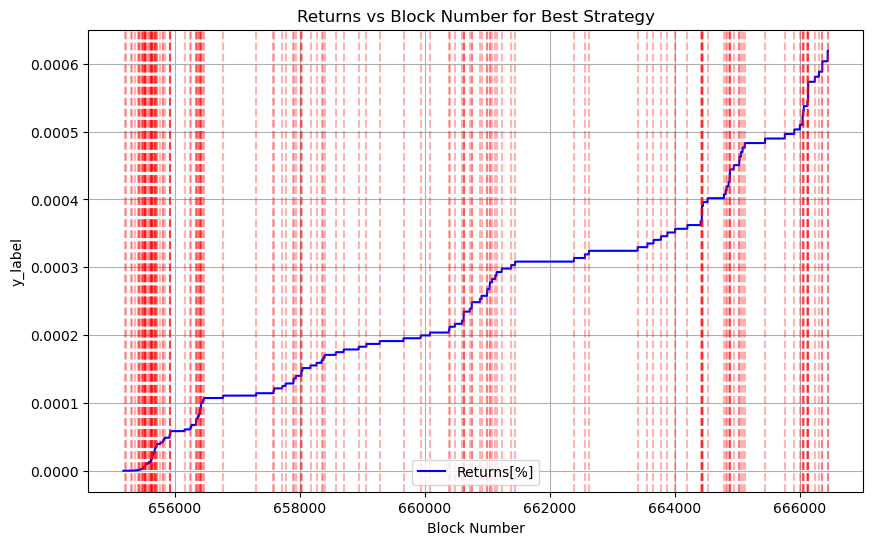

In [43]:
# Convert the optimization results to a DataFrame for analysis
optimization_df = pd.DataFrame(optimization_results)

# Sort by net earnings
optimization_df_sorted = optimization_df.sort_values(by="Returns (%)", ascending=False)

# Display the top 5 performing combinations
top_results = optimization_df_sorted.head()
print(top_results)

def plot_returns_vs_block(returns_df, title, y_plot, y_label, plot_color):
    """
    Plot the returns vs. block number curve with vertical lines for il_bool = 1.

    Parameters:
    - returns_df (pd.DataFrame): DataFrame containing 'block_number', 'returns', and 'il_bool' columns.
    - title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot returns vs block number
    plt.plot(returns_df['block_number'], returns_df[y_plot], label=y_label, color=plot_color)
#     plt.plot(returns_df['block_number'], returns_df['il_in_token1'], label="IL", color='yellow')
#     plt.plot(returns_df['block_number'], returns_df['net_earnings'], label="net_earnings", color='green')
    
    # Plot vertical lines where il_bool == 1
    for block_number in returns_df[returns_df['il_bool'] == 1]['block_number']:
        plt.axvline(x=block_number, color='red', linestyle='--', alpha=0.3)
    
    # Labels, title, and legend
    plt.xlabel('Block Number')
    plt.ylabel('y_label')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# Assuming you want to plot the returns for the best performing combination
best_block_vs_returns_df = block_vs_returns_all[optimization_df_sorted.index[0]]  # Get the best block vs returns


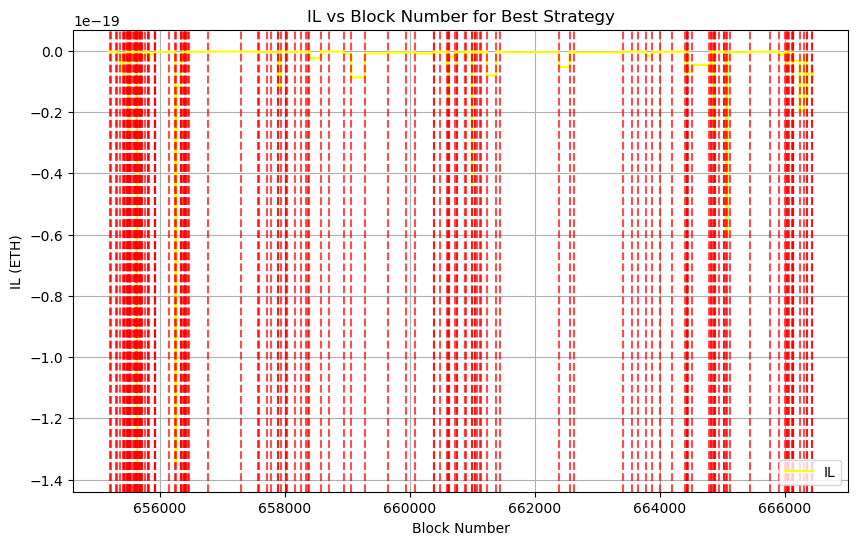

In [40]:
plot_returns_vs_block(best_block_vs_returns_df, title="Returns vs Block Number for Best Strategy", y_plot = 'returns', y_label= "Returns[%]", plot_color = "blue")
plot_returns_vs_block(best_block_vs_returns_df, title="IL vs Block Number for Best Strategy", y_plot = 'il_in_token1', y_label= "IL", plot_color = "yellow")

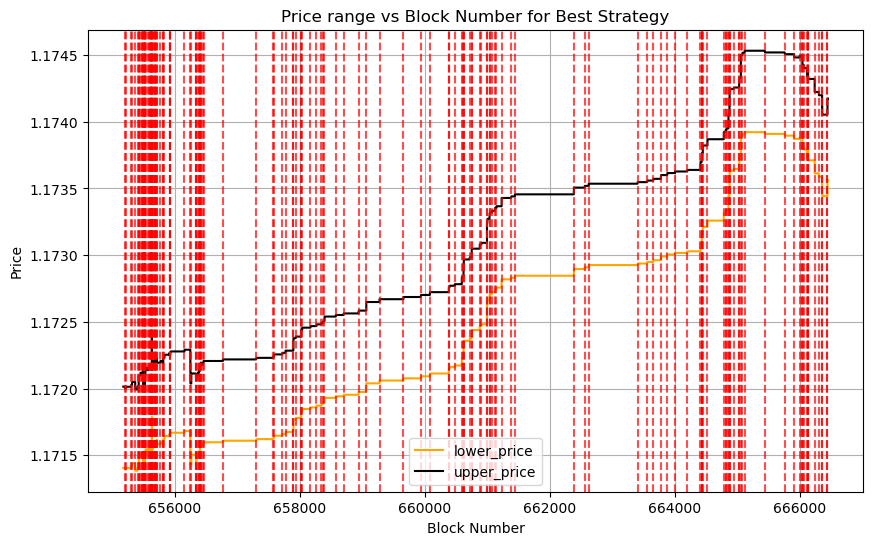

In [44]:
def plot_returns_vs_block(returns_df, title="Returns vs Block Number"):
    """
    Plot the returns vs. block number curve with vertical lines for il_bool = 1.

    Parameters:
    - returns_df (pd.DataFrame): DataFrame containing 'block_number', 'returns', and 'il_bool' columns.
    - title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot returns vs block number
    plt.plot(returns_df['block_number'], returns_df['liquidity_lower_bound'], label="lower_price", color='orange')
    plt.plot(returns_df['block_number'], returns_df['liquidity_upper_bound'], label="upper_price", color='black')
    
    # Plot vertical lines where il_bool == 1
    for block_number in returns_df[returns_df['il_bool'] == 1]['block_number']:
        plt.axvline(x=block_number, color='red', linestyle='--', alpha=0.7)
    
    # Labels, title, and legend
    plt.xlabel('Block Number')
    plt.ylabel('Price')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# Assuming you want to plot the returns for the best performing combination
best_block_vs_returns_df = block_vs_returns_all[optimization_df_sorted.index[0]]  # Get the best block vs returns
plot_returns_vs_block(best_block_vs_returns_df, title="Price range vs Block Number for Best Strategy")

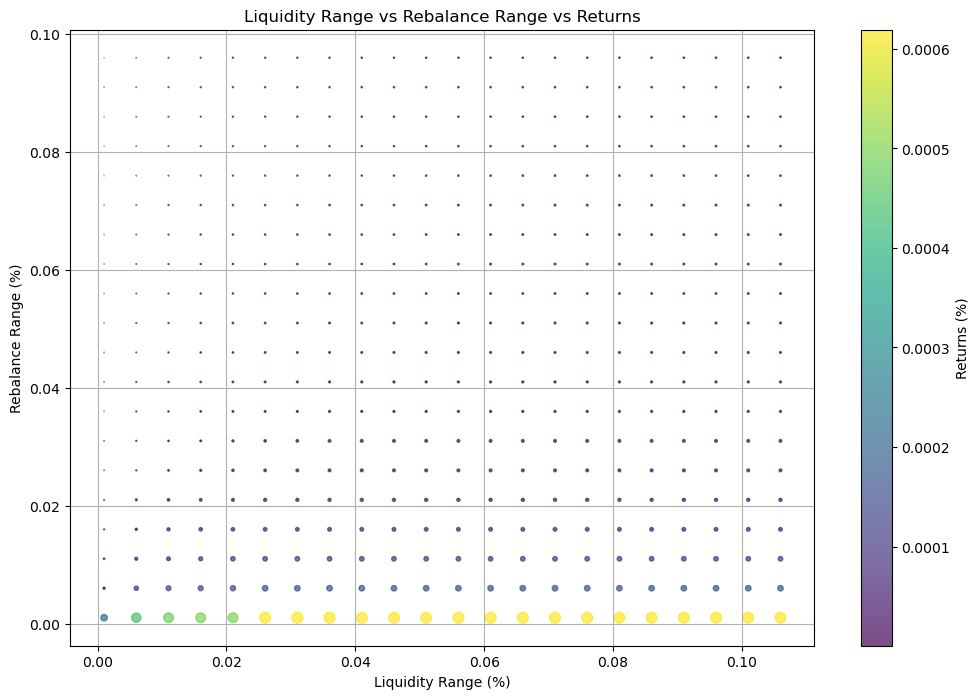

In [47]:
# Filter the DataFrame to include only rows where Rebalance Range (%) is between 0 and 0.1
filtered_df = optimization_df[(optimization_df['Rebalance Range (%)'] >= 0) & 
                              (optimization_df['Rebalance Range (%)'] <= 0.1)]


plt.figure(figsize=(12, 8))

# Create a scatter plot where the color represents the returns and the size of the points represents the magnitude of returns
scatter = plt.scatter(filtered_df['Liquidity Range (%)'],
                      filtered_df['Rebalance Range (%)'],
                      c=filtered_df['Returns (%)'],  # Color represents returns
                      s=filtered_df['Returns (%)'] *10**5,  # Size represents returns, adjust the multiplier for better scaling
                      cmap='viridis',  # Colormap for returns
                      alpha=0.7)

# Add a color bar to the plot
cbar = plt.colorbar(scatter)
cbar.set_label('Returns (%)')

# Set the title and axis labels
plt.title('Liquidity Range vs Rebalance Range vs Returns')
plt.xlabel('Liquidity Range (%)')
plt.ylabel('Rebalance Range (%)')

plt.grid(True)
plt.show()


# Plotting liquidity range against returns 

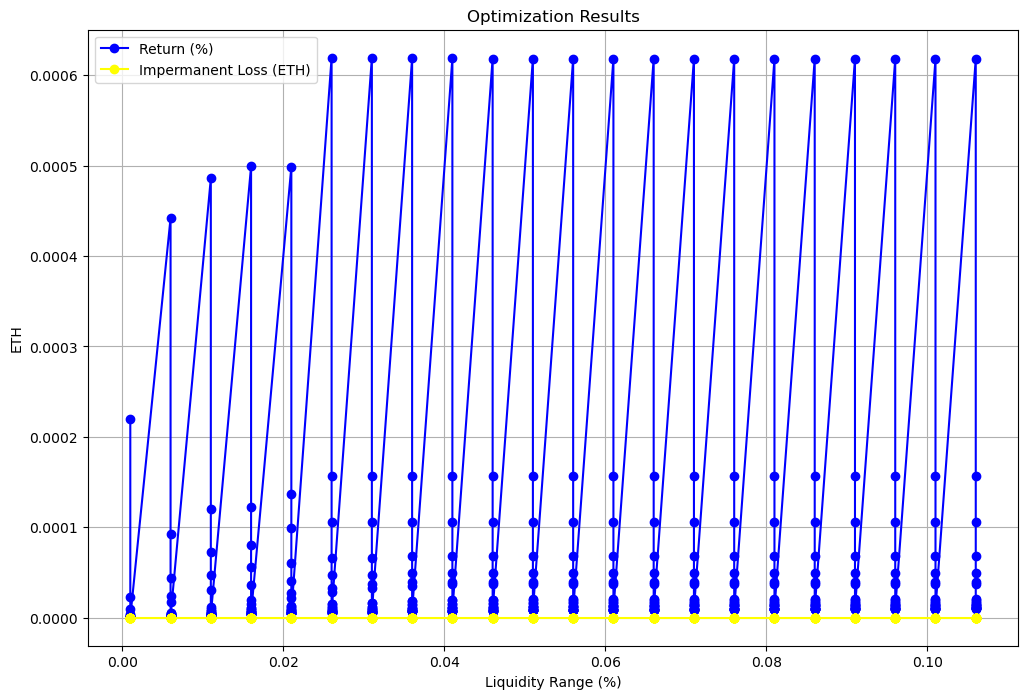

In [48]:
# Plotting the optimization results
plt.figure(figsize=(12, 8))

# Plot Net Earnings
# plt.plot(optimization_df['Liquidity Range (%)'], optimization_df['Net Earnings (ETH)'], marker='o', label='Net Earnings (ETH)', color = "green")

# Plot Total Fees Earned
plt.plot(optimization_df['Liquidity Range (%)'], optimization_df['Returns (%)'], marker='o', label='Return (%)', color = "blue")

# Plot Impermanent Loss
plt.plot(optimization_df['Liquidity Range (%)'], optimization_df['Impermanent Loss (ETH)'], marker='o', label='Impermanent Loss (ETH)', color = "yellow")

plt.title('Optimization Results')
plt.xlabel('Liquidity Range (%)')
plt.ylabel('ETH')
plt.legend()
plt.grid(True)
plt.show()

# Plotting rebalance range against returns 

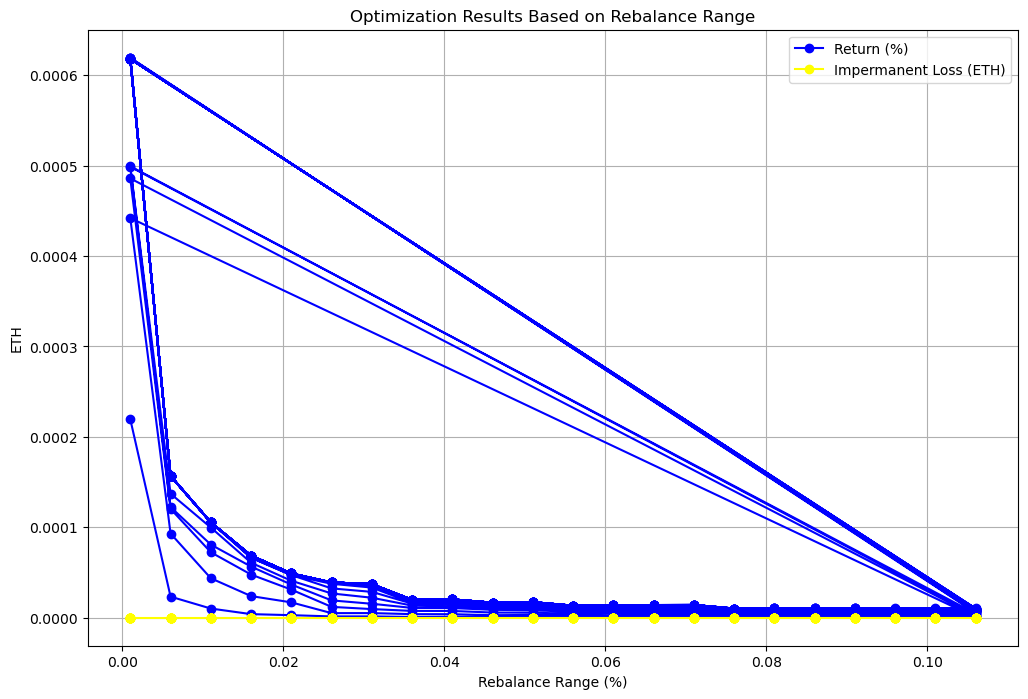

In [49]:
# Plotting the optimization results for Rebalance Range
plt.figure(figsize=(12, 8))

# Plot Net Earnings
# plt.plot(optimization_df['Rebalance Range (%)'], optimization_df['Net Earnings (ETH)'], marker='o', label='Net Earnings (ETH)', color = "green")

# Plot Total Fees Earned
plt.plot(optimization_df['Rebalance Range (%)'], optimization_df['Returns (%)'], marker='o', label='Return (%)', color = "blue")

# Plot Impermanent Loss
plt.plot(optimization_df['Rebalance Range (%)'], optimization_df['Impermanent Loss (ETH)'], marker='o', label='Impermanent Loss (ETH)', color = "yellow")

plt.title('Optimization Results Based on Rebalance Range')
plt.xlabel('Rebalance Range (%)')
plt.ylabel('ETH')
plt.legend()
plt.grid(True)
plt.show()
